In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
import os
import string

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

import xarray as xr

import torch
import torch.nn as nn
import joblib

sys.path.append('/home/sachin/miniconda3/envs/torch_env/') #sever
from esn_dts_openloop import ESN, Tikhonov

Load MLP

In [2]:
class MonteCarloDropout(nn.Dropout):
    def forward(self, input):
        return nn.functional.dropout(input, self.p, True, self.inplace)

class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_size, 2056),
            nn.ReLU(),
            #MonteCarloDropout(0.2),
            nn.Linear(2056, 1024),
            nn.ReLU(),
            #MonteCarloDropout(0.2), 
	        nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            MonteCarloDropout(0.2), 
            nn.Linear(128, 1),
        )

    def forward(self, x):
        return self.layers(x)

In [3]:
#mid = "100pct_3day-removed" #potential
#mid = "x-cond-3day" #conducvity
#mid = "y-cond-3day" #conducvity
#mid = "xy-cond-3day" #conducvity
mid = "current-3day" #current

#target = 'potential'
target = 'current'
#target = 'conductivity'

In [4]:

path = f"/home/sachin/Documents/NIPR/Research/Data/ML/MLP/{mid}_outputs"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLP(10)
model.load_state_dict(torch.load(f'{path}/model_{mid}.pt'))
model.eval()

#path = r'/home/ryuho/Documents/reddy/research/SMRAI/Data/REPPU/200/pbig5min.dat' #Ubuntu
path_reppu = r'/home/sachin/Documents/NIPR/Research/Data/REPPU/fbig5min.dat' #Server

#read the REPPU data
with open (path_reppu) as f:
    rectype = np.dtype(np.float32)
    reppu_data = np.fromfile(f, rectype) #size = 109,900,800

reppu_data = reppu_data.reshape(-1,30, 80)
reppu_data

mhd_data = pd.read_csv('mhd_dates.csv')
expanded_dt = pd.concat([pd.Series(pd.date_range(start, end)) 
    for start, end in zip(mhd_data['start'], mhd_data['end'])])

time_res = 5

if time_res == 1:
    time_step = 1440
else :
    time_step = 288

data_reshaped = reppu_data.reshape(len(expanded_dt), time_step, 30, 80) 

# Define coordinates
time = np.arange(time_step)
lat = np.linspace(50, 90, 30) #30 intervals between 53.1° to 89.7°
lon = np.linspace(1, 360, 80) #80 intervals between 1.6° to 357.6°

# Create 'dt' variable combining dates and five-minute intervals
dt = []
for day in expanded_dt:
    for t in time:
        dt.append(day + pd.Timedelta(minutes=t*time_res))
dt = np.array(dt) #convert from list to numpy array

# Create xarray Dataset
ds = xr.Dataset({target: (['dt', 'lat', 'lon'], data_reshaped.reshape(-1, 30, 80))},
        coords={'dt': dt, 'lat': lat, 'lon': lon})

omni_df = pd.read_csv('omni_mhd_5min.csv')
#omni_df = pd.read_csv(omni_mhd_path+'omni_mhd_5min.csv')
omni_df.set_index('dt', inplace=True) #set the datetime as the index
omni_df = omni_df.ffill().bfill()
omni_df = omni_df.dropna() #drop any remaining NaNs

omni_ds = xr.Dataset(omni_df)
omni_ds['dt'] = pd.to_datetime(omni_ds['dt']) #convert the index to datetime

#merge OMNI with REPPU data
reppu_omni_ds = ds.merge(omni_ds, join='outer')
reppu_omni_ds['mlt'] = np.mod(reppu_omni_ds['lon'] / 15, 24)

#select date range
reppu_omni_ds = reppu_omni_ds.sortby('dt')


#multipliers for potential and current
#reppu_omni_ds['potential'] = reppu_omni_ds['potential'] * 1e-3
reppu_omni_ds['current'] = reppu_omni_ds['current'] * 1e6


reppu_omni_ds

<xarray.Dataset> Size: 442MB
Dimensions:         (dt: 45792, lat: 30, lon: 80)
Coordinates:
  * dt              (dt) datetime64[ns] 366kB 2021-05-10 ... 2022-08-19T23:55:00
  * lat             (lat) float64 240B 50.0 51.38 52.76 ... 87.24 88.62 90.0
  * lon             (lon) float64 640B 1.0 5.544 10.09 ... 350.9 355.5 360.0
Data variables:
    current         (dt, lat, lon) float32 440MB 0.0 0.0 0.0 ... 0.07385 0.07306
    BY_GSE          (dt) float64 366kB 4.72 4.35 4.61 4.65 ... -2.49 -2.04 -1.92
    BZ_GSE          (dt) float64 366kB 6.24 6.55 6.56 6.89 ... -4.47 -4.64 -4.5
    flow_speed      (dt) float64 366kB 344.0 344.0 345.0 ... 655.0 653.0 658.0
    proton_density  (dt) float64 366kB 12.11 11.44 12.65 ... 6.22 5.59 5.34
    tilt_angle      (dt) float64 366kB 0.253 0.2497 0.2465 ... 0.1769 0.1735
    mlt             (lon) float64 640B 0.06667 0.3696 0.6726 ... 23.39 23.7 0.0

In [5]:
date_1_ds = reppu_omni_ds.sel(dt=slice('2021-05-10 00:00:00', '2021-05-10 23:55:00')) #shock, moderate storm. R 0.06/1, Kp2
date_2_ds = reppu_omni_ds.sel(dt=slice('2021-10-11 00:00:00', '2021-10-11 23:55:00')) #shock event. R 0.65/1 Kp4-
date_3_ds = reppu_omni_ds.sel(dt=slice('2022-01-30 00:00:00', '2022-01-30 23:55:00')) #shock event R 0.77/1 Kp3

In [6]:
def prepare_mlp_data(ds_date):

    def split_to_df(ds):
        ds = ds.copy()
        df = ds.to_dataframe().reset_index()

        df=df[['dt','mlt','lon','lat',target,'BY_GSE','BZ_GSE','flow_speed','proton_density','tilt_angle']]

        df_2 = df.copy()

        df_2['mlt_sin'] = np.sin(df_2['mlt']*(2.*np.pi/24))
        df_2['mlt_cos'] = np.cos(df_2['mlt']*(2.*np.pi/24))

        df_2['lon_sin'] = np.sin((df_2['lon']-1)*(2.*np.pi/360))
        df_2['lon_cos'] = np.cos((df_2['lon']-1)*(2.*np.pi/360))

        df_2 = df_2.drop(columns=['dt', target])
        #df_2 = df_2.drop(columns=['dt', 'potential', 'lat', 'mlt_sin', 'mlt_cos', 'lon_sin', 'lon_cos'])

        return df, df_2

    df_raw, df_proc = split_to_df(ds_date)

    with open(f'{path}/scaler_{mid}.pkl', 'rb') as f:
        scaler = pickle.load(f)

    col_names = df_proc.columns
    norm_arr = scaler.transform(df_proc)
    df_proc = pd.DataFrame(norm_arr, columns=col_names)
    df_proc = df_proc.drop(columns=['mlt','lon'])

    df_proc = df_proc.to_numpy()
    df_proc = torch.tensor(df_proc, dtype=torch.float32)

    batch_size = 10000  # Adjust this value based on your system's memory capacity
    n = len(df_proc)
    predictions = []

    for i in range(0, n, batch_size):
        batch = df_proc[i:i+batch_size]
        batch_pred = model(batch).detach().cpu().numpy()
        batch_pred = batch_pred.flatten()
        predictions.extend(batch_pred)

    df_raw[f'{target}_pred'] = predictions

    def to_xr(df):
        df = df.copy()
        df['dt'] = pd.to_datetime(df['dt'])
        df = df.set_index(['dt', 'lat', 'lon'])
        ds = df.to_xarray()

        ds['mlt'] = ds['BY_GSE'].mean(dim=['lat', 'dt'])
        ds['BY_GSE'] = ds['BY_GSE'].mean(dim=['lat', 'lon'])
        ds['BZ_GSE'] = ds['BZ_GSE'].mean(dim=['lat', 'lon'])
        ds['flow_speed'] = ds['flow_speed'].mean(dim=['lat', 'lon'])
        ds['proton_density'] = ds['proton_density'].mean(dim=['lat', 'lon'])
        ds['tilt_angle'] = ds['tilt_angle'].mean(dim=['lat', 'lon'])
        
        return ds

    ds_pred = to_xr(df_raw)

    return ds_pred

date_1_ds = prepare_mlp_data(date_1_ds)
date_2_ds = prepare_mlp_data(date_2_ds)
date_3_ds = prepare_mlp_data(date_3_ds)


/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


Load ESN 

In [7]:
def load_esn(ds):

   ds = ds.copy()

   with open('/home/sachin/Documents/NIPR/Research/Data/ESN/models/SMRAI2_current_ID8.pkl', 'rb') as f:
      model = pickle.load(f)

   pca_reload = pickle.load(open('/home/sachin/Documents/NIPR/Research/Data/ESN/models/ESN_current_pca_ID8.pkl','rb'))

   prediction_arr = ds.drop_vars([f'{target}_pred','mlt',f'{target}']).to_array().values.T
   prediction = model.predict(prediction_arr)

   prediction_original = pca_reload.inverse_transform(prediction)
   prediction_original = prediction_original.reshape(-1, 30, 80)

   ds[f'{target}_pred_esn'] = (('dt', 'lat', 'lon'), prediction_original)

   return ds

date_1_ds = load_esn(date_1_ds)
date_2_ds = load_esn(date_2_ds)
date_3_ds = load_esn(date_3_ds)

Conductivity

KeyError: "No variable named 'conductivity'. Variables on the dataset include ['dt', 'lat', 'lon', 'mlt', 'current', ..., 'flow_speed', 'proton_density', 'tilt_angle', 'current_pred', 'current_pred_esn']"

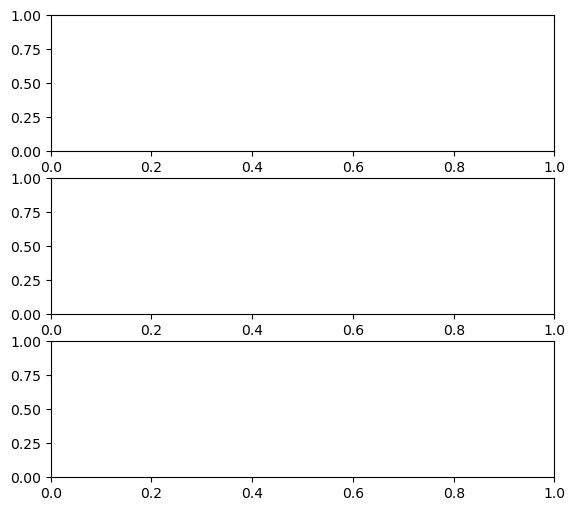

In [8]:
fig, ax = plt.subplots(3, 1, figsize=(6.5, 6))

#date 1
date_1_ds['conductivity'].mean(dim=['lat','lon']).plot(ax=ax[0], label='REPPU', color='black')
date_1_ds['conductivity_pred'].mean(dim=['lat','lon']).plot(ax=ax[0], label='MLP', color='#648FFF')
date_1_ds['conductivity_pred_esn'].mean(dim=['lat','lon']).plot(ax=ax[0], label='ESN', color='#FFB000')
ax[0].text(0.9, 1.15, 'Kp: 2', transform=ax[0].transAxes, fontsize=10.5, va='top')

RMSE_mlp_1 = np.sqrt(np.mean((date_1_ds['conductivity'].values.flatten() - date_1_ds['conductivity_pred'].values.flatten())**2))
NRMSE_mlp_1 = RMSE_mlp_1 / (np.max(date_1_ds['conductivity'].values.flatten()) - np.min(date_1_ds['conductivity'].values.flatten()))
RMSE_esn_1 = np.sqrt(np.mean((date_1_ds['conductivity'].values.flatten() - date_1_ds['conductivity_pred_esn'].values.flatten())**2))
NRMSE_esn_1 = RMSE_esn_1 / (np.max(date_1_ds['conductivity'].values.flatten()) - np.min(date_1_ds['conductivity'].values.flatten()))
R_mlp_1 = np.corrcoef(date_1_ds['conductivity'].values.flatten(), date_1_ds['conductivity_pred'].values.flatten())[0,1]
R_esn_1 = np.corrcoef(date_1_ds['conductivity'].values.flatten(), date_1_ds['conductivity_pred_esn'].values.flatten())[0,1]

ax[0].text(1.05, 1, f'MLP:\nNRMSE: {NRMSE_mlp_1:.2f}\nR: {R_mlp_1:.2f}', transform=ax[0].transAxes, fontsize=10.5, va='top')
ax[0].text(1.05, 0.5, f'ESN:\nNRMSE: {NRMSE_esn_1:.2f}\nR: {R_esn_1:.2f}', transform=ax[0].transAxes, fontsize=10.5, va='top')

#date 2
date_2_ds['conductivity'].mean(dim=['lat','lon']).plot(ax=ax[1], label='REPPU', color='black')
date_2_ds['conductivity_pred'].mean(dim=['lat','lon']).plot(ax=ax[1], label='MLP', color='#648FFF')
date_2_ds['conductivity_pred_esn'].mean(dim=['lat','lon']).plot(ax=ax[1], label='ESN', color='#FFB000')
ax[1].text(0.9, 1.15, 'Kp: 4-', transform=ax[1].transAxes, fontsize=10.5, va='top')

RMSE_mlp_2 = np.sqrt(np.mean((date_2_ds['conductivity'].values.flatten() - date_2_ds['conductivity_pred'].values.flatten())**2))
NRMSE_mlp_2 = RMSE_mlp_2 / (np.max(date_2_ds['conductivity'].values.flatten()) - np.min(date_2_ds['conductivity'].values.flatten()))
RMSE_esn_2 = np.sqrt(np.mean((date_2_ds['conductivity'].values.flatten() - date_2_ds['conductivity_pred_esn'].values.flatten())**2))
NRMSE_esn_2 = RMSE_esn_2 / (np.max(date_2_ds['conductivity'].values.flatten()) - np.min(date_2_ds['conductivity'].values.flatten()))
R_mlp_2 = np.corrcoef(date_2_ds['conductivity'].values.flatten(), date_2_ds['conductivity_pred'].values.flatten())[0,1]
R_esn_2 = np.corrcoef(date_2_ds['conductivity'].values.flatten(), date_2_ds['conductivity_pred_esn'].values.flatten())[0,1]

ax[1].text(1.05, 1, f'MLP:\nNRMSE: {NRMSE_mlp_2:.2f}\nR: {R_mlp_2:.2f}', transform=ax[1].transAxes, fontsize=10.5, va='top')
ax[1].text(1.05, 0.5, f'ESN:\nNRMSE: {NRMSE_esn_2:.2f}\nR: {R_esn_2:.2f}', transform=ax[1].transAxes, fontsize=10.5, va='top')

#date 3
date_3_ds['conductivity'].mean(dim=['lat','lon']).plot(ax=ax[2], label='REPPU', color='black')
date_3_ds['conductivity_pred'].mean(dim=['lat','lon']).plot(ax=ax[2], label='MLP', color='#648FFF')
date_3_ds['conductivity_pred_esn'].mean(dim=['lat','lon']).plot(ax=ax[2], label='ESN', color='#FFB000')
ax[2].text(0.9, 1.15, 'Kp: 3', transform=ax[2].transAxes, fontsize=10.5, va='top')

RMSE_mlp_3 = np.sqrt(np.mean((date_3_ds['conductivity'].values.flatten() - date_3_ds['conductivity_pred'].values.flatten())**2))
NRMSE_mlp_3 = RMSE_mlp_3 / (np.max(date_3_ds['conductivity'].values.flatten()) - np.min(date_3_ds['conductivity'].values.flatten()))
RMSE_esn_3 = np.sqrt(np.mean((date_3_ds['conductivity'].values.flatten() - date_3_ds['conductivity_pred_esn'].values.flatten())**2))
NRMSE_esn_3 = RMSE_esn_3 / (np.max(date_3_ds['conductivity'].values.flatten()) - np.min(date_3_ds['conductivity'].values.flatten()))
R_mlp_3 = np.corrcoef(date_3_ds['conductivity'].values.flatten(), date_3_ds['conductivity_pred'].values.flatten())[0,1]
R_esn_3 = np.corrcoef(date_3_ds['conductivity'].values.flatten(), date_3_ds['conductivity_pred_esn'].values.flatten())[0,1]

ax[2].text(1.05, 1, f'MLP:\nNRMSE: {NRMSE_mlp_3:.2f}\nR: {R_mlp_3:.2f}', transform=ax[2].transAxes, fontsize=10.5, va='top')
ax[2].text(1.05, 0.5, f'ESN:\nNRMSE: {NRMSE_esn_3:.2f}\nR: {R_esn_3:.2f}', transform=ax[2].transAxes, fontsize=10.5, va='top')

for i, date in enumerate([date_1_ds, date_2_ds, date_3_ds]):
    dt_str = date['dt'].values[0].astype('str')
    ax[i].set_title(f'{dt_str[:10]}', fontsize=10.5, pad=5)
    ax[i].set_ylabel('X Conductivity\n[S/m]')
    ax[i].set_xlabel('')
    ax[i].legend()
    ax[i].grid()


plt.tight_layout()
#plt.savefig(f'mlp_esn_comparison_x-cond.png', dpi=400)


Potential

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(6.5, 6))

date_1_ds['potential'].mean(dim=['lat','lon']).plot(ax=ax[0], label='REPPU', color='black')
date_1_ds['potential_pred'].mean(dim=['lat','lon']).plot(ax=ax[0], label='MLP', color='#648FFF')
date_1_ds['potential_pred_esn'].mean(dim=['lat','lon']).plot(ax=ax[0], label='ESN', color='#FFB000')
ax[0].text(0.9, 1.15, 'Kp: 2', transform=ax[0].transAxes, fontsize=10.5, va='top')

RMSE_mlp_1 = np.sqrt(np.mean((date_1_ds['potential'].values.flatten() - date_1_ds['potential_pred'].values.flatten())**2))
NRMSE_mlp_1 = RMSE_mlp_1 / (np.max(date_1_ds['potential'].values.flatten()) - np.min(date_1_ds['potential'].values.flatten()))
RMSE_esn_1 = np.sqrt(np.mean((date_1_ds['potential'].values.flatten() - date_1_ds['potential_pred_esn'].values.flatten())**2))
NRMSE_esn_1 = RMSE_esn_1 / (np.max(date_1_ds['potential'].values.flatten()) - np.min(date_1_ds['potential'].values.flatten()))
R_mlp_1 = np.corrcoef(date_1_ds['potential'].values.flatten(), date_1_ds['potential_pred'].values.flatten())[0,1]
R_esn_1 = np.corrcoef(date_1_ds['potential'].values.flatten(), date_1_ds['potential_pred_esn'].values.flatten())[0,1]

ax[0].text(1.05, 1, f'MLP:\nNRMSE: {NRMSE_mlp_1:.2f}\nR: {R_mlp_1:.2f}', transform=ax[0].transAxes, fontsize=10.5, va='top')
ax[0].text(1.05, 0.5, f'ESN:\nNRMSE: {NRMSE_esn_1:.2f}\nR: {R_esn_1:.2f}', transform=ax[0].transAxes, fontsize=10.5, va='top')

date_2_ds['potential'].mean(dim=['lat','lon']).plot(ax=ax[1], label='REPPU', color='black')
date_2_ds['potential_pred'].mean(dim=['lat','lon']).plot(ax=ax[1], label='MLP', color='#648FFF')
date_2_ds['potential_pred_esn'].mean(dim=['lat','lon']).plot(ax=ax[1], label='ESN', color='#FFB000')
ax[1].text(0.9, 1.15, 'Kp: 4-', transform=ax[1].transAxes, fontsize=10.5, va='top')

RMSE_mlp_2 = np.sqrt(np.mean((date_2_ds['potential'].values.flatten() - date_2_ds['potential_pred'].values.flatten())**2))
NRMSE_mlp_2 = RMSE_mlp_2 / (np.max(date_2_ds['potential'].values.flatten()) - np.min(date_2_ds['potential'].values.flatten()))
RMSE_esn_2 = np.sqrt(np.mean((date_2_ds['potential'].values.flatten() - date_2_ds['potential_pred_esn'].values.flatten())**2))
NRMSE_esn_2 = RMSE_esn_2 / (np.max(date_2_ds['potential'].values.flatten()) - np.min(date_2_ds['potential'].values.flatten()))
R_mlp_2 = np.corrcoef(date_2_ds['potential'].values.flatten(), date_2_ds['potential_pred'].values.flatten())[0,1]
R_esn_2 = np.corrcoef(date_2_ds['potential'].values.flatten(), date_2_ds['potential_pred_esn'].values.flatten())[0,1]

ax[1].text(1.05, 1, f'MLP:\nNRMSE: {NRMSE_mlp_2:.2f}\nR: {R_mlp_2:.2f}', transform=ax[1].transAxes, fontsize=10.5, va='top')
ax[1].text(1.05, 0.5, f'ESN:\nNRMSE: {NRMSE_esn_2:.2f}\nR: {R_esn_2:.2f}', transform=ax[1].transAxes, fontsize=10.5, va='top')

date_3_ds['potential'].mean(dim=['lat','lon']).plot(ax=ax[2], label='REPPU', color='black')
date_3_ds['potential_pred'].mean(dim=['lat','lon']).plot(ax=ax[2], label='MLP', color='#648FFF')
date_3_ds['potential_pred_esn'].mean(dim=['lat','lon']).plot(ax=ax[2], label='ESN', color='#FFB000')
ax[2].text(0.9, 1.15, 'Kp: 3', transform=ax[2].transAxes, fontsize=10.5, va='top')

RMSE_mlp_3 = np.sqrt(np.mean((date_3_ds['potential'].values.flatten() - date_3_ds['potential_pred'].values.flatten())**2))
NRMSE_mlp_3 = RMSE_mlp_3 / (np.max(date_3_ds['potential'].values.flatten()) - np.min(date_3_ds['potential'].values.flatten()))
RMSE_esn_3 = np.sqrt(np.mean((date_3_ds['potential'].values.flatten() - date_3_ds['potential_pred_esn'].values.flatten())**2))
NRMSE_esn_3 = RMSE_esn_3 / (np.max(date_3_ds['potential'].values.flatten()) - np.min(date_3_ds['potential'].values.flatten()))
R_mlp_3 = np.corrcoef(date_3_ds['potential'].values.flatten(), date_3_ds['potential_pred'].values.flatten())[0,1]
R_esn_3 = np.corrcoef(date_3_ds['potential'].values.flatten(), date_3_ds['potential_pred_esn'].values.flatten())[0,1]

ax[2].text(1.05, 1, f'MLP:\nNRMSE: {NRMSE_mlp_3:.2f}\nR: {R_mlp_3:.2f}', transform=ax[2].transAxes, fontsize=10.5, va='top')
ax[2].text(1.05, 0.5, f'ESN:\nNRMSE: {NRMSE_esn_3:.2f}\nR: {R_esn_3:.2f}', transform=ax[2].transAxes, fontsize=10.5, va='top')

for i, date in enumerate([date_1_ds, date_2_ds, date_3_ds]):
    dt_str = date['dt'].values[0].astype('str')
    ax[i].set_title(f'{dt_str[:10]}', fontsize=10.5, pad=5)
    ax[i].set_ylabel('Potential [kV]')
    ax[i].set_xlabel('')
    ax[i].legend()
    ax[i].grid()

plt.tight_layout()
#plt.savefig(f'mlp_esn_comparison_potential.png', dpi=400)


Current

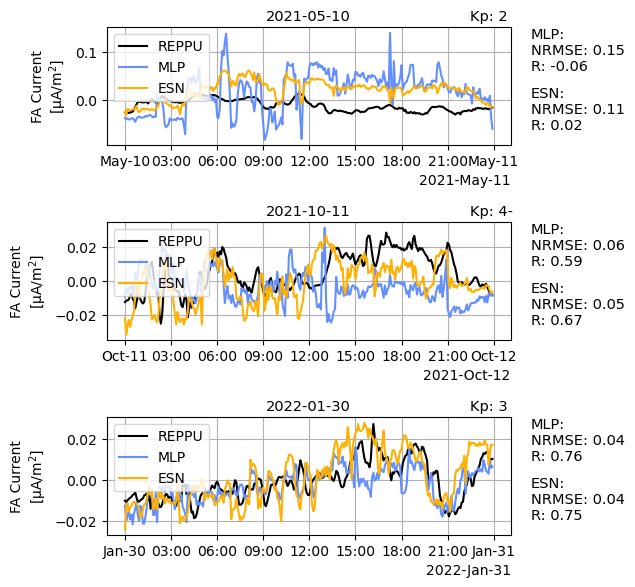

In [12]:
fig, ax = plt.subplots(3, 1, figsize=(6.5, 6))
date_1_ds['current'].mean(dim=['lat','lon']).plot(ax=ax[0], label='REPPU', color='black')
date_1_ds['current_pred'].mean(dim=['lat','lon']).plot(ax=ax[0], label='MLP', color='#648FFF')
date_1_ds['current_pred_esn'].mean(dim=['lat','lon']).plot(ax=ax[0], label='ESN', color='#FFB000')
ax[0].text(0.9, 1.15, 'Kp: 2', transform=ax[0].transAxes, fontsize=10.5, va='top')

RMSE_mlp_1 = np.sqrt(np.mean((date_1_ds['current'].values.flatten() - date_1_ds['current_pred'].values.flatten())**2))
NRMSE_mlp_1 = RMSE_mlp_1 / (np.max(date_1_ds['current'].values.flatten()) - np.min(date_1_ds['current'].values.flatten()))
RMSE_esn_1 = np.sqrt(np.mean((date_1_ds['current'].values.flatten() - date_1_ds['current_pred_esn'].values.flatten())**2))
NRMSE_esn_1 = RMSE_esn_1 / (np.max(date_1_ds['current'].values.flatten()) - np.min(date_1_ds['current'].values.flatten()))
R_mlp_1 = np.corrcoef(date_1_ds['current'].values.flatten(), date_1_ds['current_pred'].values.flatten())[0,1]
R_esn_1 = np.corrcoef(date_1_ds['current'].values.flatten(), date_1_ds['current_pred_esn'].values.flatten())[0,1]

ax[0].text(1.05, 1, f'MLP:\nNRMSE: {NRMSE_mlp_1:.2f}\nR: {R_mlp_1:.2f}', transform=ax[0].transAxes, fontsize=10.5, va='top')
ax[0].text(1.05, 0.5, f'ESN:\nNRMSE: {NRMSE_esn_1:.2f}\nR: {R_esn_1:.2f}', transform=ax[0].transAxes, fontsize=10.5, va='top')

date_2_ds['current'].mean(dim=['lat','lon']).plot(ax=ax[1], label='REPPU', color='black')
date_2_ds['current_pred'].mean(dim=['lat','lon']).plot(ax=ax[1], label='MLP', color='#648FFF')
date_2_ds['current_pred_esn'].mean(dim=['lat','lon']).plot(ax=ax[1], label='ESN', color='#FFB000')
ax[1].text(0.9, 1.15, 'Kp: 4-', transform=ax[1].transAxes, fontsize=10.5, va='top')

RMSE_mlp_2 = np.sqrt(np.mean((date_2_ds['current'].values.flatten() - date_2_ds['current_pred'].values.flatten())**2))
NRMSE_mlp_2 = RMSE_mlp_2 / (np.max(date_2_ds['current'].values.flatten()) - np.min(date_2_ds['current'].values.flatten()))
RMSE_esn_2 = np.sqrt(np.mean((date_2_ds['current'].values.flatten() - date_2_ds['current_pred_esn'].values.flatten())**2))
NRMSE_esn_2 = RMSE_esn_2 / (np.max(date_2_ds['current'].values.flatten()) - np.min(date_2_ds['current'].values.flatten()))
R_mlp_2 = np.corrcoef(date_2_ds['current'].values.flatten(), date_2_ds['current_pred'].values.flatten())[0,1]
R_esn_2 = np.corrcoef(date_2_ds['current'].values.flatten(), date_2_ds['current_pred_esn'].values.flatten())[0,1]

ax[1].text(1.05, 1, f'MLP:\nNRMSE: {NRMSE_mlp_2:.2f}\nR: {R_mlp_2:.2f}', transform=ax[1].transAxes, fontsize=10.5, va='top')
ax[1].text(1.05, 0.5, f'ESN:\nNRMSE: {NRMSE_esn_2:.2f}\nR: {R_esn_2:.2f}', transform=ax[1].transAxes, fontsize=10.5, va='top')

date_3_ds['current'].mean(dim=['lat','lon']).plot(ax=ax[2], label='REPPU', color='black')
date_3_ds['current_pred'].mean(dim=['lat','lon']).plot(ax=ax[2], label='MLP', color='#648FFF')
date_3_ds['current_pred_esn'].mean(dim=['lat','lon']).plot(ax=ax[2], label='ESN', color='#FFB000')
ax[2].text(0.9, 1.15, 'Kp: 3', transform=ax[2].transAxes, fontsize=10.5, va='top')

RMSE_mlp_3 = np.sqrt(np.mean((date_3_ds['current'].values.flatten() - date_3_ds['current_pred'].values.flatten())**2))
NRMSE_mlp_3 = RMSE_mlp_3 / (np.max(date_3_ds['current'].values.flatten()) - np.min(date_3_ds['current'].values.flatten()))
RMSE_esn_3 = np.sqrt(np.mean((date_3_ds['current'].values.flatten() - date_3_ds['current_pred_esn'].values.flatten())**2))
NRMSE_esn_3 = RMSE_esn_3 / (np.max(date_3_ds['current'].values.flatten()) - np.min(date_3_ds['current'].values.flatten()))
R_mlp_3 = np.corrcoef(date_3_ds['current'].values.flatten(), date_3_ds['current_pred'].values.flatten())[0,1]
R_esn_3 = np.corrcoef(date_3_ds['current'].values.flatten(), date_3_ds['current_pred_esn'].values.flatten())[0,1]

ax[2].text(1.05, 1, f'MLP:\nNRMSE: {NRMSE_mlp_3:.2f}\nR: {R_mlp_3:.2f}', transform=ax[2].transAxes, fontsize=10.5, va='top')
ax[2].text(1.05, 0.5, f'ESN:\nNRMSE: {NRMSE_esn_3:.2f}\nR: {R_esn_3:.2f}', transform=ax[2].transAxes, fontsize=10.5, va='top')

current = r'$\mathrm{\mu}$A/m$^2$'
for i, date in enumerate([date_1_ds, date_2_ds, date_3_ds]):
    dt_str = date['dt'].values[0].astype('str')
    ax[i].set_title(f'{dt_str[:10]}', fontsize=10.5, pad=5)
    ax[i].set_ylabel(f'FA Current\n[{current}]')
    ax[i].set_xlabel('')
    ax[i].legend()
    ax[i].grid()

plt.tight_layout()
plt.savefig(f'mlp_esn_comparison_current.png', dpi=400)

score

In [ ]:

diff_rmse = np.sqrt(np.mean((df_comp[target] - df_comp[f'{target}_pred'])**2))
diff_nrmse = diff_rmse / (df_comp[target].max() - df_comp[target].min())
diff_mae = np.mean(np.abs(df_comp[target] - df_comp[f'{target}_pred']))
diff_R = np.corrcoef(df_comp[target], df_comp[f'{target}_pred'])[0,1]

def skill(m, o):
    skill = 1 - (np.sum((m - o)**2) / 
            np.sum((o - np.mean(o))**2))

    return skill  
    
diff_skill = skill(df_comp[f'{target}_pred'], df_comp[target])

print(f'RMSE: {diff_rmse:.2f}')
print(f'NRMSE: {diff_nrmse:.3f}')
print(f'MAE: {diff_mae:.2f}')
print(f'R: {diff_R:.2f}')
print(f'PE: {diff_skill:.2f}')